## Task 2 Predictive Analytics

subtask:
* Explore correlations between annual salry and various customer attributes.
* Build a simple regression model to predict the annual salry for each customer
* Build a decision-tree based model to predict salary

## Import Labraies 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data 
df=pd.read_excel('ANZ synthesised transaction clean dataset.xlsx')
df.head()

,status,card_present_flag,account,long_lat,txn_description,merchant_id,balance,date,gender,age,...,transaction_id,customer_id,merchant_long_lat,movement,dayofweek,hour,longtitude,latitude,merchant_longtitude,merchant_latitude
0,authorized,1.0,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,35.39,2018-08-01,F,26,...,a623070bfead4541a6b0fff8a09e706c,CUS-2487424745,153.38 -27.99,debit,2,1,153.41,-27.95,153.38,-27.99
1,authorized,0.0,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,21.20,2018-08-01,F,26,...,13270a2a902145da9db4c951e04b51b9,CUS-2487424745,151.21 -33.87,debit,2,1,153.41,-27.95,151.21,-33.87
2,authorized,1.0,ACC-1222300524,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,5.71,2018-08-01,M,38,...,feb79e7ecd7048a5a36ec889d1a94270,CUS-2142601169,151.21 -33.87,debit,2,1,151.23,-33.94,151.21,-33.87
3,authorized,1.0,ACC-1037050564,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,2117.22,2018-08-01,F,40,...,2698170da3704fd981b15e64a006079e,CUS-1614226872,153.05 -26.68,debit,2,1,153.10,-27.66,153.05,-26.68
4,authorized,1.0,ACC-1598451071,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,17.95,2018-08-01,F,26,...,329adf79878c4cf0aeb4188b4691c266,CUS-2487424745,153.44 -28.06,debit,2,1,153.41,-27.95,153.44,-28.06


The dataset was already cleaned, but we still need to do the feature engineering as data preparation for the model.

## Feature Engineering 

Since we need to model annual salary, first we need to calculate the annual salary for each customer and create the features that can help us to predict their annual salary


### Annual Salary 

In [3]:
df.columns

Index(['status', 'card_present_flag', 'account', 'long_lat', 'txn_description',
       'merchant_id', 'balance', 'date', 'gender', 'age', 'merchant_suburb',
       'merchant_state', 'extraction', 'amount', 'transaction_id',
       'customer_id', 'merchant_long_lat', 'movement', 'dayofweek', 'hour',
       'longtitude', 'latitude', 'merchant_longtitude', 'merchant_latitude'],
      dtype='object')

In [4]:
annual_salaries=df.query('txn_description=="PAY/SALARY"')
annual_salaries=pd.DataFrame(annual_salaries.groupby(['customer_id'],as_index=False)['amount'].sum())
annual_salaries['annual_salary']=annual_salaries['amount']*365/92
annual_salaries.head()

,customer_id,amount,annual_salary
0,CUS-1005756958,12616.11,50053.045109
1,CUS-1117979751,25050.55,99385.334239
2,CUS-1140341822,11499.06,45621.270652
3,CUS-1147642491,22248.07,88266.799457
4,CUS-1196156254,27326.11,108413.371196


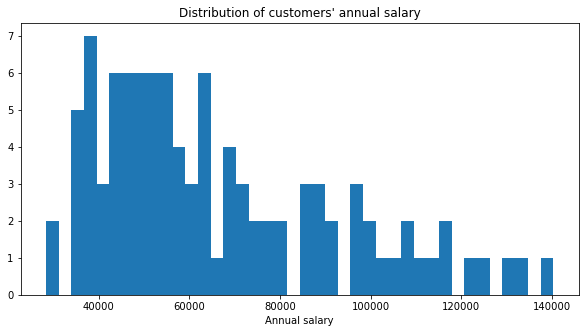

In [5]:
# Show the distribution of the 
plt.figure(figsize = (10, 5))
plt.hist(annual_salaries.annual_salary,bins=40)
plt.title("Distribution of customers' annual salary")
plt.xlabel("Annual salary");

In [6]:
customer_id=df.customer_id.unique()
len(customer_id)

100

### Predictor variables

In this section,we will create some new features for each customer:
In this section, we will create the following features each customer:
* Average transaction amount
* Median balance
* State of residence

And also the features already have: 
* Age
* Gender

In [7]:
#Average transaction amount
avg_trans_amount = []
for customer in customer_id:
    array =df.loc[df.customer_id ==customer, "amount"]
    avg_trans_amount.append(array.mean())
avg_trans_amount[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

In [8]:
#Median balance
median_balance = []
for customer in customer_id:
    array = df.loc[df.customer_id ==customer, "balance"]
    median_balance.append(array.median())
median_balance[:5]

[1580.4, 1132.66, 3618.5, 5616.63, 6162.45]

In [9]:
#State of residence(assume the transaction occured state is the residence state)
state = []
for customer in customer_id:
    array = df.loc[df.customer_id ==customer, "merchant_state"]
    state.append(mode(array))
state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

In [10]:
#Age
age = []
for customer in customer_id:
    array = df.loc[df.customer_id ==customer, "age"]
    age.append(mode(array))
age[:5]

[26, 38, 40, 20, 43]

In [11]:
#Gender
gender = []
for customer in customer_id:
    array = df.loc[df.customer_id ==customer, "gender"]
    gender.append(mode(array))
gender[:5]

['F', 'M', 'F', 'M', 'F']

## Merge the data into one dataset 

In [12]:
features_df = pd.DataFrame({"customer_id": customer_id,
                            "avg_trans_amount": avg_trans_amount,
                            "median_balance": median_balance, 
                            "state": state,
                            "age": age,
                            "gender": gender})
features_df.head()

,customer_id,avg_trans_amount,median_balance,state,age,gender
0,CUS-2487424745,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,166.508358,6162.45,VIC,43,F


In [13]:
merged_df=pd.concat([features_df,annual_salaries.annual_salary],axis=1)
merged_df.head()

,customer_id,avg_trans_amount,median_balance,state,age,gender,annual_salary
0,CUS-2487424745,45.348772,1580.40,QLD,26,F,50053.045109
1,CUS-2142601169,78.206106,1132.66,NSW,38,M,99385.334239
2,CUS-1614226872,74.465019,3618.50,QLD,40,F,45621.270652
3,CUS-2688605418,159.304186,5616.63,NSW,20,M,88266.799457
4,CUS-4123612273,166.508358,6162.45,VIC,43,F,108413.371196


In [14]:
merged_df.isnull().sum()

customer_id          0
avg_trans_amount     0
median_balance       0
state               43
age                  0
gender               0
annual_salary        0
dtype: int64

In [15]:
merged_df.state.value_counts()

VIC    21
NSW    19
QLD     8
WA      7
NT      2
Name: state, dtype: int64

In [16]:
merged_df.state.fillna(value='VIC',inplace=True)
merged_df.isnull().sum()

customer_id         0
avg_trans_amount    0
median_balance      0
state               0
age                 0
gender              0
annual_salary       0
dtype: int64

Now, there is no null value and we can for the next step,analysis the correlation and build model!

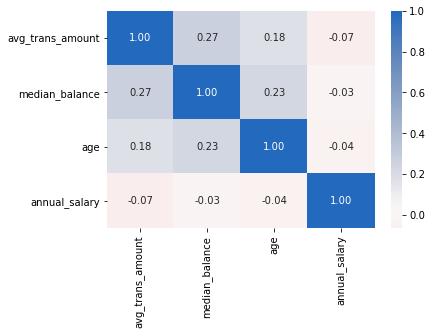

In [17]:
#Check the correlation
sns.heatmap(merged_df.corr(),annot=True,fmt='.2f',cmap='vlag_r',center=0);

It seems each numeric variables didn't have much correlation

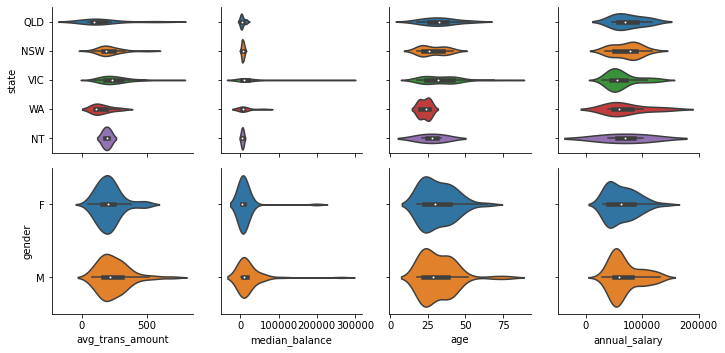

In [18]:
g=sns.PairGrid(data=merged_df,x_vars=['avg_trans_amount','median_balance','age','annual_salary'],
               y_vars=['state','gender'])
g.map(sns.violinplot,innner='quantile');

## Predictive Analytics

Train test split

In [19]:
X = merged_df.drop(["customer_id", "annual_salary"], axis = 1)
y = merged_df.annual_salary

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [21]:
merged_df.drop(columns='customer_id')

## Linear regression

In [24]:
one_hot=OneHotEncoder(sparse = False)
scaler = StandardScaler()
column_transform = make_column_transformer((one_hot, ["state", "gender"]), (scaler, [ "avg_trans_amount", "median_balance", "age"]))


In [26]:
lr = LinearRegression()
lr_pipeline = make_pipeline(column_transform, lr)

In [29]:
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

In [32]:
print("RMSE: ", round(np.sqrt(mean_squared_error(lr_pred, y_test))))

RMSE:  30346


## Decision tree 

In [33]:
tree = DecisionTreeRegressor()
tree_pipeline = make_pipeline(column_transform, tree)

In [35]:
tree_pipeline.fit(X_train, y_train)
tree_pred = tree_pipeline.predict(X_test)

In [37]:
print("RMSE: ", round(np.sqrt(mean_squared_error(tree_pred, y_test))))

RMSE:  34341


The decision tree model's RSME is smaller than linear regression but not too much 